In [87]:
from pathlib import Path
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.combine import SMOTEENN

In [88]:
def generate_test(shuffle_data_df: DataFrame):
    """take 500 rows with"""
    test_set = shuffle_data_df[4500:]

    return test_set


def generate_train_valid(shuffled_data_df: DataFrame):
    return shuffled_data_df[:4500]


def read_and_shuffle_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/full_data.csv"))

    shuffled = full_data.sample(frac=1, random_state=0)

    return shuffled


def encode_int(data):
    return data.replace(
        {
            "Male": 1,
            "Female": 0,
            "Yes": 1,
            "No": 0,
            "Urban": 1,
            "Rural": 0,
            "Private": 0,
            "Self-employed": 1,
            "Govt_job": 2,
            "children": 3,
            "Unknown": np.nan,
            "never smoked": 0,
            "formerly smoked": 1,
            "smokes": 2,
        },
    )


def impute_missing(data: DataFrame, header):
    enc = OrdinalEncoder()
    enc.fit(data)

    imputer = KNNImputer(n_neighbors=2, missing_values=np.nan, weights="uniform")
    smoking_status = imputer.fit_transform(enc.transform(data))

    #smoking_status = DataFrame(smoking_status, columns=header)["smoking_status"].apply(
    #    np.round
    #)

    #smoking_status = smoking_status.replace(
    #    [0.0, 1.0, 2.0], ["never smoked", "formerly smoked", "smokes"]
    #)

    smoking_status = DataFrame(enc.inverse_transform(smoking_status), columns=header)

    return smoking_status


def resample(data: pd.DataFrame):
    """ oversample positive cases with SMOTE and undersample negative with EEN """
    enc = OrdinalEncoder()
    enc.fit(data)
    data = DataFrame(enc.transform(data), columns=data.columns)

    X = data.drop(columns=['stroke'], axis=1)
    Y = data['stroke']

    smote_een = SMOTEENN(random_state=0, sampling_strategy='auto')

    x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled['stroke'] = y_resampled

    return DataFrame(enc.inverse_transform(x_resampled), columns=data.columns)


def prepare_data_tvt(header):
    full_data_shuffled = read_and_shuffle_data()

    full_data_shuffled[
        ["hypertension", "heart_disease", "ever_married", "smoking_status", "stroke"]
    ] = (
        full_data_shuffled[
            [
                "hypertension",
                "heart_disease",
                "ever_married",
                "smoking_status",
                "stroke",
            ]
        ]
        .replace({1: "Yes", 0: "No", "Unknown": np.nan})
    ) # ensure they don't interfere with StringLookupLayers


    full_data_shuffled["smoking_status"] = impute_missing(
        full_data_shuffled, header=full_data_shuffled.columns
    )['smoking_status']


    test_df = DataFrame(generate_test(full_data_shuffled))
    train_df = resample(DataFrame(generate_train_valid(full_data_shuffled)))

    test_df.to_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), index=False, header=False
    )
    train_df.to_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), index=False, header=False
    )

    full_data_shuffled.to_csv(
        Path().resolve().joinpath("dataset/full_data_clean.csv"), index=False
    )

    test_df.to_csv(
        Path().resolve().joinpath("dataset/test_data_names.csv"), index=False
    )
    train_df.to_csv(
        Path().resolve().joinpath("dataset/train_data_names.csv"), index=False
    )

    return test_df, train_df



In [89]:
# prepare data
CSV_HEADER = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
    "stroke",
]

train_data_path = Path().resolve().joinpath("dataset/train_data.csv")
test_data_path = Path().resolve().joinpath("dataset/test_data.csv")

train_data_file = str(train_data_path.absolute())
test_data_file = str(test_data_path.absolute())

train_data = DataFrame()
test_data = DataFrame()

try:
    train_data = pd.read_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), names=CSV_HEADER
    )
    test_data = pd.read_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), names=CSV_HEADER
    )

except:
    test_data, train_data = prepare_data_tvt(header=CSV_HEADER)


test_data, train_data = prepare_data_tvt(header=CSV_HEADER)

print(
    f"Using {len(train_data)} samples for training and {len(test_data)} for validation"
)

NUMERIC_FEATURE_NAMES = [
    "age",
    "avg_glucose_level",
    "bmi",
]  # list of numeric feature names

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(train_data["gender"].unique())),
    "hypertension": sorted(list(train_data["hypertension"].unique())),
    "heart_disease": sorted(list(train_data["heart_disease"].unique())),
    "ever_married": sorted(list(train_data["ever_married"].unique())),
    "work_type": sorted(list(train_data["work_type"].unique())),
    "Residence_type": sorted(list(train_data["Residence_type"].unique())),
    "smoking_status": sorted(list(train_data["smoking_status"].unique())),
}

# metadata

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# The name of the target feature.
TARGET_FEATURE_NAME = "stroke"
# A list of the labels of the target features.
TARGET_LABELS = ["Yes", "No"]

Using 6625 samples for training and 481 for validation


In [90]:
# model hyperparameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 100

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


In [91]:
# data proccessing pipeline

target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    """dataset from, csv"""
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [92]:
def create_model_inputs():
    """Create model inputs"""
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


def encode_inputs(inputs, embedding_dims):
    """Encode features"""

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    print(encoded_categorical_feature_list)

    return encoded_categorical_feature_list, numerical_feature_list


In [93]:
# training and evaluation


def run_experiment(
    model,
    train_data_file,
    test_data_file,
    model_output,
    num_epochs,
    learning_rate,
    batch_size,
):
    """Implement a training and evaluation procedure"""

    # optimizer = tfa.optimizers.AdamW(
    #    learning_rate=learning_rate, weight_decay=WEIGHT_DECAY
    # )
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    model.save(model_output, save_format='tf')

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history


In [94]:
# MLP block
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    """MLP block"""

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    """MLP model without transformer layers"""

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.relu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_14')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_15')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_16')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_17')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_18')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_19')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_20')>]
Total model weights: 68115


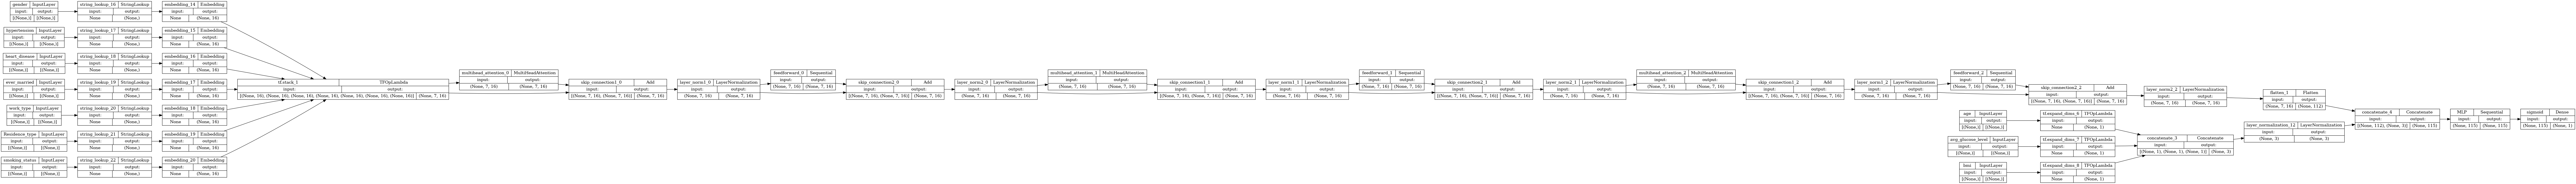

In [95]:
# tabtransformer block


def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    # use_column_embedding=True
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_21')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_22')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_23')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_24')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_25')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_26')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_27')>]
Total model weights: 81233


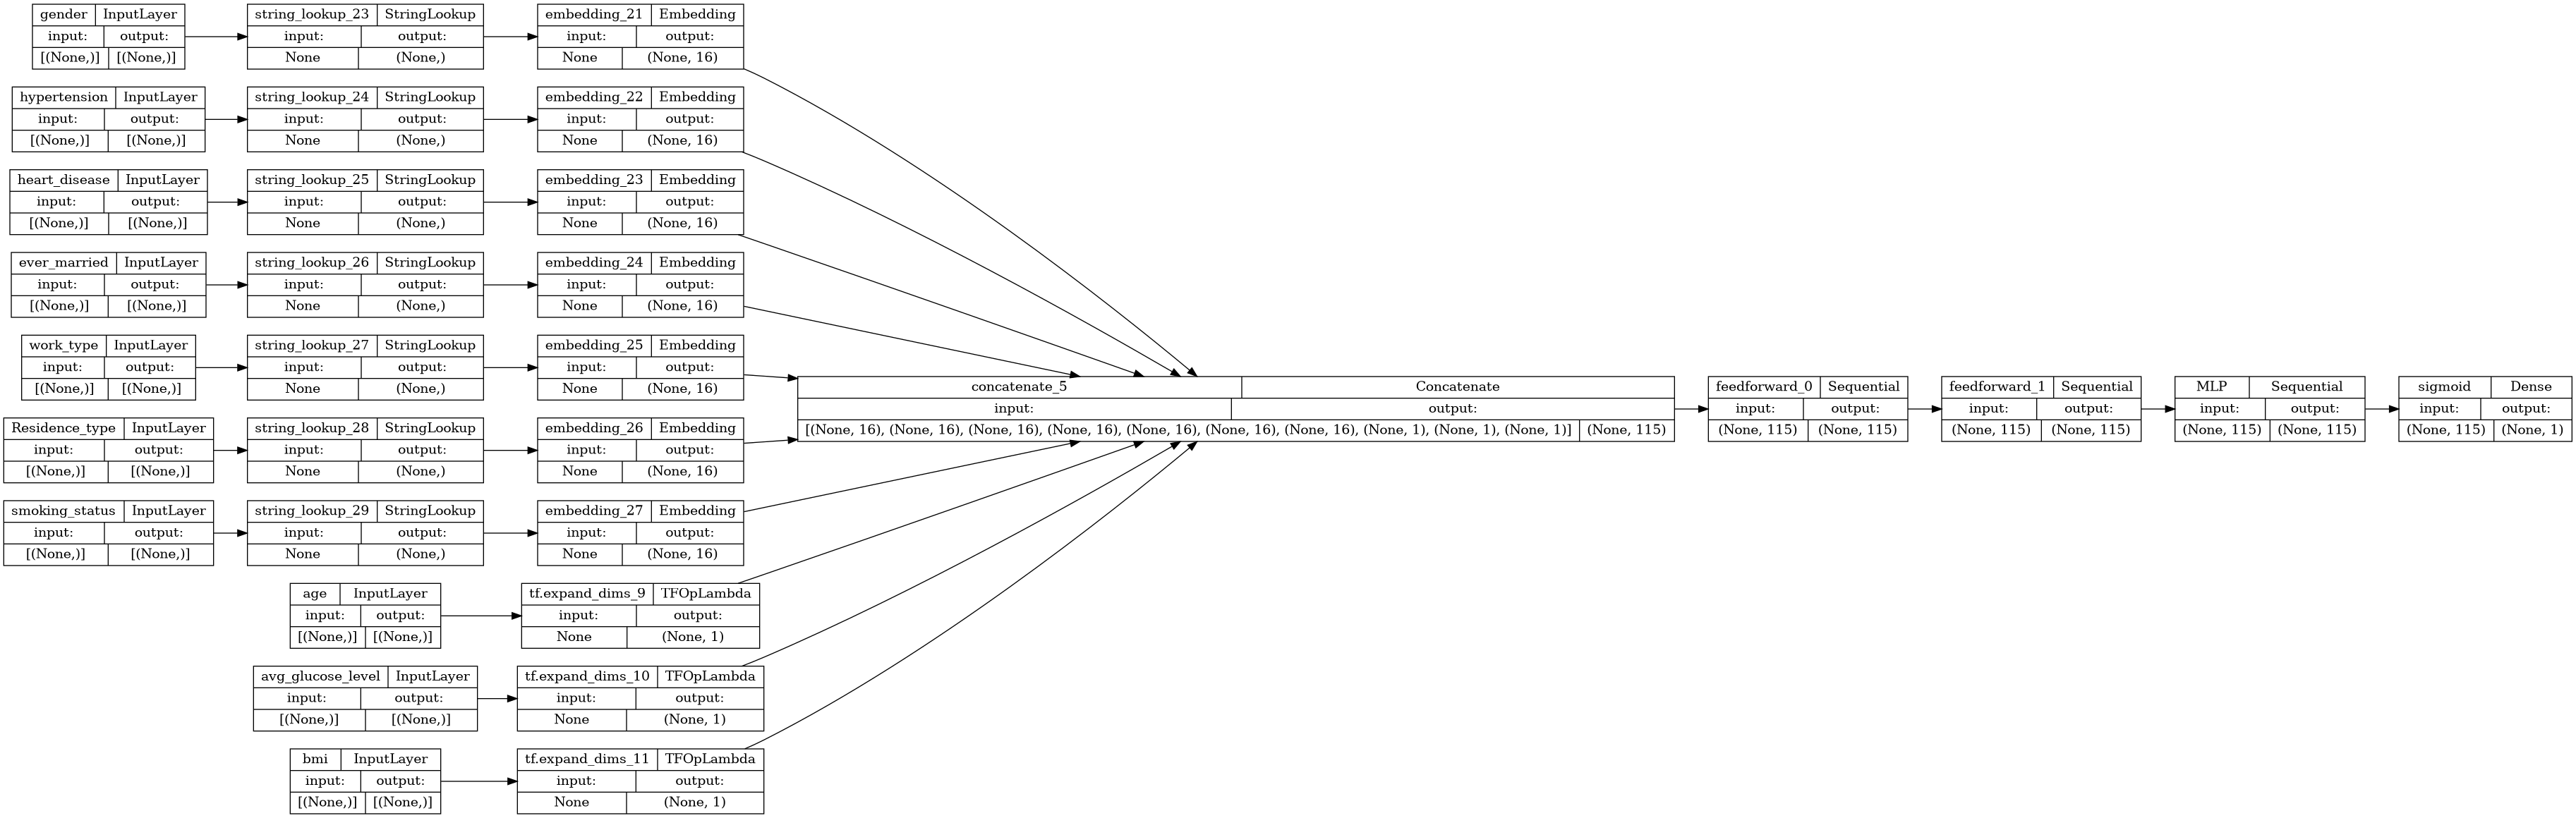

In [96]:
# define a baseline model without transformer layer

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [100]:
# run and evaluate baseline model
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    model_output='./model/mlp_model.pb',
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
208/208 [==============================] - 4s 8ms/step - loss: 0.2043 - accuracy: 0.9230 - val_loss: 0.6162 - val_accuracy: 0.8004
Epoch 2/100
208/208 [==============================] - 1s 6ms/step - loss: 0.1929 - accuracy: 0.9268 - val_loss: 0.5735 - val_accuracy: 0.8004
Epoch 3/100
208/208 [==============================] - 1s 6ms/step - loss: 0.1948 - accuracy: 0.9239 - val_loss: 0.6420 - val_accuracy: 0.7900
Epoch 4/100
208/208 [==============================] - 1s 6ms/step - loss: 0.1885 - accuracy: 0.9285 - val_loss: 0.5387 - val_accuracy: 0.8274
Epoch 5/100
208/208 [==============================] - 1s 6ms/step - loss: 0.1880 - accuracy: 0.9289 - val_loss: 0.5855 - val_accuracy: 0.7983
Epoch 6/100
208/208 [==============================] - 1s 6ms/step - loss: 0.1819 - accuracy: 0.9268 - val_loss: 0.5221 - val_accuracy: 0.8337
Epoch 7/100
208/208 [==============================] - 1s 6ms/step - loss: 0.1829 - accuracy: 0.9319 - val_loss: 0

INFO:tensorflow:Assets written to: ./model/mlp_model.pb/assets


INFO:tensorflow:Assets written to: ./model/mlp_model.pb/assets


Validation accuracy: 77.34%


In [98]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    model_output='./model/tabtransformer_model.pb',
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/100
208/208 [==============================] - 9s 18ms/step - loss: 0.5497 - accuracy: 0.7407 - val_loss: 0.8820 - val_accuracy: 0.6008
Epoch 2/100
208/208 [==============================] - 3s 14ms/step - loss: 0.4832 - accuracy: 0.7722 - val_loss: 0.9320 - val_accuracy: 0.5260
Epoch 3/100
208/208 [==============================] - 3s 14ms/step - loss: 0.4643 - accuracy: 0.7828 - val_loss: 0.8403 - val_accuracy: 0.5613
Epoch 4/100
208/208 [==============================] - 3s 14ms/step - loss: 0.4506 - accuracy: 0.7918 - val_loss: 0.7227 - val_accuracy: 0.5759
Epoch 5/100
208/208 [==============================] - 3s 14ms/step - loss: 0.4344 - accuracy: 0.7949 - val_loss: 0.7399 - val_accuracy: 0.6195
Epoch 6/100
208/208 [==============================] - 3s 14ms/step - loss: 0.4267 - accuracy: 0.8018 - val_loss: 0.7478 - val_accuracy: 0.6133
Epoch 7/100
208/208 [==============================] - 3s 14ms/step - loss: 0.4196 - accuracy: 0.8060 - val_

INFO:tensorflow:Assets written to: ./model/tabtransformer_model.pb/assets


INFO:tensorflow:Assets written to: ./model/tabtransformer_model.pb/assets


Validation accuracy: 67.15%
